In [2]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy
from scipy import interpolate
from scipy.misc import derivative
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8))  # Larger figure sizes
plt.rc('image', origin='lower')  # Make image zero on bottom
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] =  16.0

i_units = units.Quantity(1, unit="kW m-2 sr-1 Hz-1")

## Getting data and inverting profiles

Note that in data we have $I_{\nu}^{obs}$.

In [3]:
DATA_FILE = 'SST_sunspot_617_2020_08_07.fits' 
data = QTable.read(DATA_FILE)

#calculating inverted porofiles
data['intensity_inverted'] = data['intensity'][0] - data['intensity']
data['stokes_v_inverted'] = data['stokes_v'][0] - data['stokes_v']

rest_wavelength = 617.30 * units.nm #FeI

## Plotting intensity

In [172]:
def plot_intensity(data, ax, wavelength_index, xmin=None, xmax=None, ymin=None, ymax=None):
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    im = ax.imshow(data['intensity'][wavelength_index].value, cmap='inferno')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(r"Intensity [{}]".format(data['intensity'].unit))
    
    return im

## Calculating moments

In [4]:
sp = data['intensity_inverted'] #spectral profile
wv = data['wavelength']
wave0 = rest_wavelength

#calculating moments
moment1 = numpy.trapz(wv[:, numpy.newaxis, numpy.newaxis] * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2 = numpy.trapz((wv[:, numpy.newaxis, numpy.newaxis] - moment1)**2 * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2[moment2 < 0] = 0

## Spectral velocities

In [5]:
#line of sight velocity 
v_los = (constants.c * (wave0 - moment1) / wave0).to('km/s')

width = (numpy.sqrt(moment2) * constants.c / wave0).to('km/s')

In [6]:
def plot_los_velocity(v_los, ax, xmin=None, xmax=None, ymin=None, ymax=None):
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
    im = ax.imshow(v_los.value, cmap='RdBu')
    im.set_clim(-3,3)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(r'Velocity [km s$^{-1}$]')
    
    return im

## Brightness temperatures

Planck function:
\begin{equation} 
   B_\nu(T) = \frac{2h\nu^3}{c^2} 
                  \frac{1}{\mathrm{e}^{h\nu/ kT}-1}
\end{equation}

Inverted Planck function:
\begin{equation}
    \mathrm{e}^{h\nu/ kT}  
    = \frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1
\end{equation}

\begin{equation}
    h\nu/ kT  
    = \ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}
\end{equation}

\begin{equation}
    T = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

Inserting $\left(B_\nu(T_b)\right)^{-1} = I_{\nu}^{obs}$ gives

\begin{equation}
    T_b = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2}\left(I_{\nu}^{obs}\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

In [7]:
#adding brightness temperature to dataset
k, h, c = constants.k_B, constants.h, constants.c

nu = data['wavelength'].to(units.Hz, equivalencies=units.spectral())
intensity = data['intensity']

T_b = h*nu/k * numpy.log((2*h*nu**3)/(c**2 * intensity.T*units.sr) + 1)**(-1)
T_b = T_b.decompose()

data['brightness_temperature'] = T_b.T

In [8]:
def plot_brightness_temperature(data, ax, wavelength_index, xmin=None, xmax=None, ymin=None, ymax=None):  
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
    im = ax.imshow(data['brightness_temperature'][wavelength_index].value, cmap='inferno')
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(r'Temperature [K]')

    return im

## Gaussian fit using moments

$$
  f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right).
$$

$$
\frac{\partial f}{\partial x} = -f(x, \mu, \sigma) \frac{x-\mu}{\sigma^2}.
$$

In [9]:
def gaussian(x, mu, var): 
    return 1/(numpy.sqrt(var)*numpy.sqrt(2*numpy.pi))*numpy.exp(-0.5*(x-mu)**2/var)

def dgaussian_dx(x, mu, var, f=gaussian):
    return - f * (x-mu)/var

def scaleBetween(unscaledNum, minAllowed, maxAllowed, minNum, maxNum):
    """
    This is for scaling the gaussian with the right units
    """
    return (maxAllowed - minAllowed) * (unscaledNum - minNum) / (maxNum - minNum) + minAllowed;

In [126]:
def gaussian_fit(data, moment1, moment2, wavelengths, x, y):
    """
    Finds gaussian fit at given point x,y for an array of wavelengths
    Returns dict with gaussian fit for the intensity, inverted intensity and their derivatives
    """
    #setting up dict for different fits
    fits = {}
    
    fits['intensity_inverted'] = gaussian(wavelengths\
                                                   ,moment1[x,y], moment2[x,y])
    #fixing units
    fits['intensity_inverted'] *= units.nm * i_units
    #scaling
    fits['intensity_inverted'] = scaleBetween(fits['intensity_inverted']\
                                              , numpy.min(data['intensity_inverted'][:,x,y])\
                                              , numpy.max(data['intensity_inverted'][:,x,y])\
                                              , numpy.min(fits['intensity_inverted'])\
                                              , numpy.max(fits['intensity_inverted']))

    fits['intensity_inverted_derivative'] = dgaussian_dx(wavelengths\
                                                         , moment1[x,y]\
                                                         , moment2[x,y]\
                                                         , fits['intensity_inverted'])

    #inverting back, but now shape is correct so only scaling needed is to add intensity[0] value
    fits['intensity'] = fits['intensity_inverted'][0] + data['intensity'][0,x,y] - fits['intensity_inverted']

    fits['intensity_derivative'] = fits['intensity_inverted_derivative'][0] - fits['intensity_inverted_derivative']
    return fits

In [120]:
def plot_gaussian_fit_on_intensity(data, moment1, moment2, wavelengths, x, y, ax, rest_wavelength=None):
    if rest_wavelength!=None:
        ax.axvline(x=rest_wavelength, ymin=0, ymax=1, linestyle='--', color='black', label=r"$\lambda_0$")
    
    fits = gaussian_fit(data, moment1, moment2, wavelengths, x, y)
    
    ax.set_xlabel("Wavelength [{}]".format(wavelengths.unit))
    ax.set_ylabel(r"Intensity [{}]".format(data['intensity'].unit))
    ax.scatter(data['wavelength'], data['intensity'][:,x,y], label="Data", color='blue')
    ax.plot(wavelengths, fits['intensity'], label="Gaussian fit", color='green')
    ax.legend()

## Interpolation

In [110]:
def plot_interpolation_on_intensity(data, wavelengths, x, y, ax, kind_='quadratic', rest_wavelength=None):
    if rest_wavelength!=None:
        ax.axvline(x=rest_wavelength, ymin=0, ymax=1, linestyle='--', color='black', label=r"$\lambda_0$")

    interpolation_function = interpolate.interp1d(data['wavelength']\
                                                  , data['intensity'][:, x, y], kind=kind_)

    ax.set_xlabel("Wavelength [{}]".format(wavelengths.unit))
    ax.set_ylabel(r"Intensity [{}]".format(data['intensity'].unit))
    ax.scatter(data['wavelength'], data['intensity'][:,x,y], label="Data", color='blue')
    ax.plot(wavelengths, interpolation_function(wavelengths), label="{} interpolation".format(kind_), color='green')
    ax.legend()

## Magnetic field strength

\begin{equation}
    B_\mathrm{los} 
    = -\frac{4 \pi m_e c}{e \bar{g} \lambda_0^2}\frac{\sum_\lambda \frac{\partial I}{\partial \lambda} V_\lambda}{\sum_\lambda\left(\frac{\partial I}{\partial \lambda}\right)^2}
\end{equation}

In [160]:
pi = numpy.pi
m_e = constants.m_e
c = constants.c
e = constants.e.si
g = 2.499 #Lande factor

def calculate_B_los(data, dI_dlambda, rest_wavelength):
    """
    This gives the line of sight magnetic field strength
    """  
    const = -4 * pi * m_e * c / (e * g * rest_wavelength**2)
    B_los = const * (numpy.sum(dIdlambda.T * data['stokes_v'][0:-1], axis=0)/ numpy.sum(dIdlambda**2,axis=2).T)
    return B_los.to('tesla')

In [167]:
def plot_B_los(data, rest_wavelength, ax, xmin=None, xmax=None, ymin=None, ymax=None, fit='diff'):
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    if fit == 'gaussian':
        #not implemented
        pass
    if fit == 'interpolation':
        #not implemented
        pass
    if fit == 'diff':
        diff_intensity = numpy.diff(data['intensity'], axis=0)
        diff_wl = numpy.diff(data['wavelength'])
        dIdlambda = diff_intensity.T/diff_wl
        B_los = calculate_B_los(data, dI_dlambda, rest_wavelength)
    
    im = ax.imshow(B_los, cmap='inferno')
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(r'Magnetic field [T]')

    return im

# TESTING THE FUNCTIONS

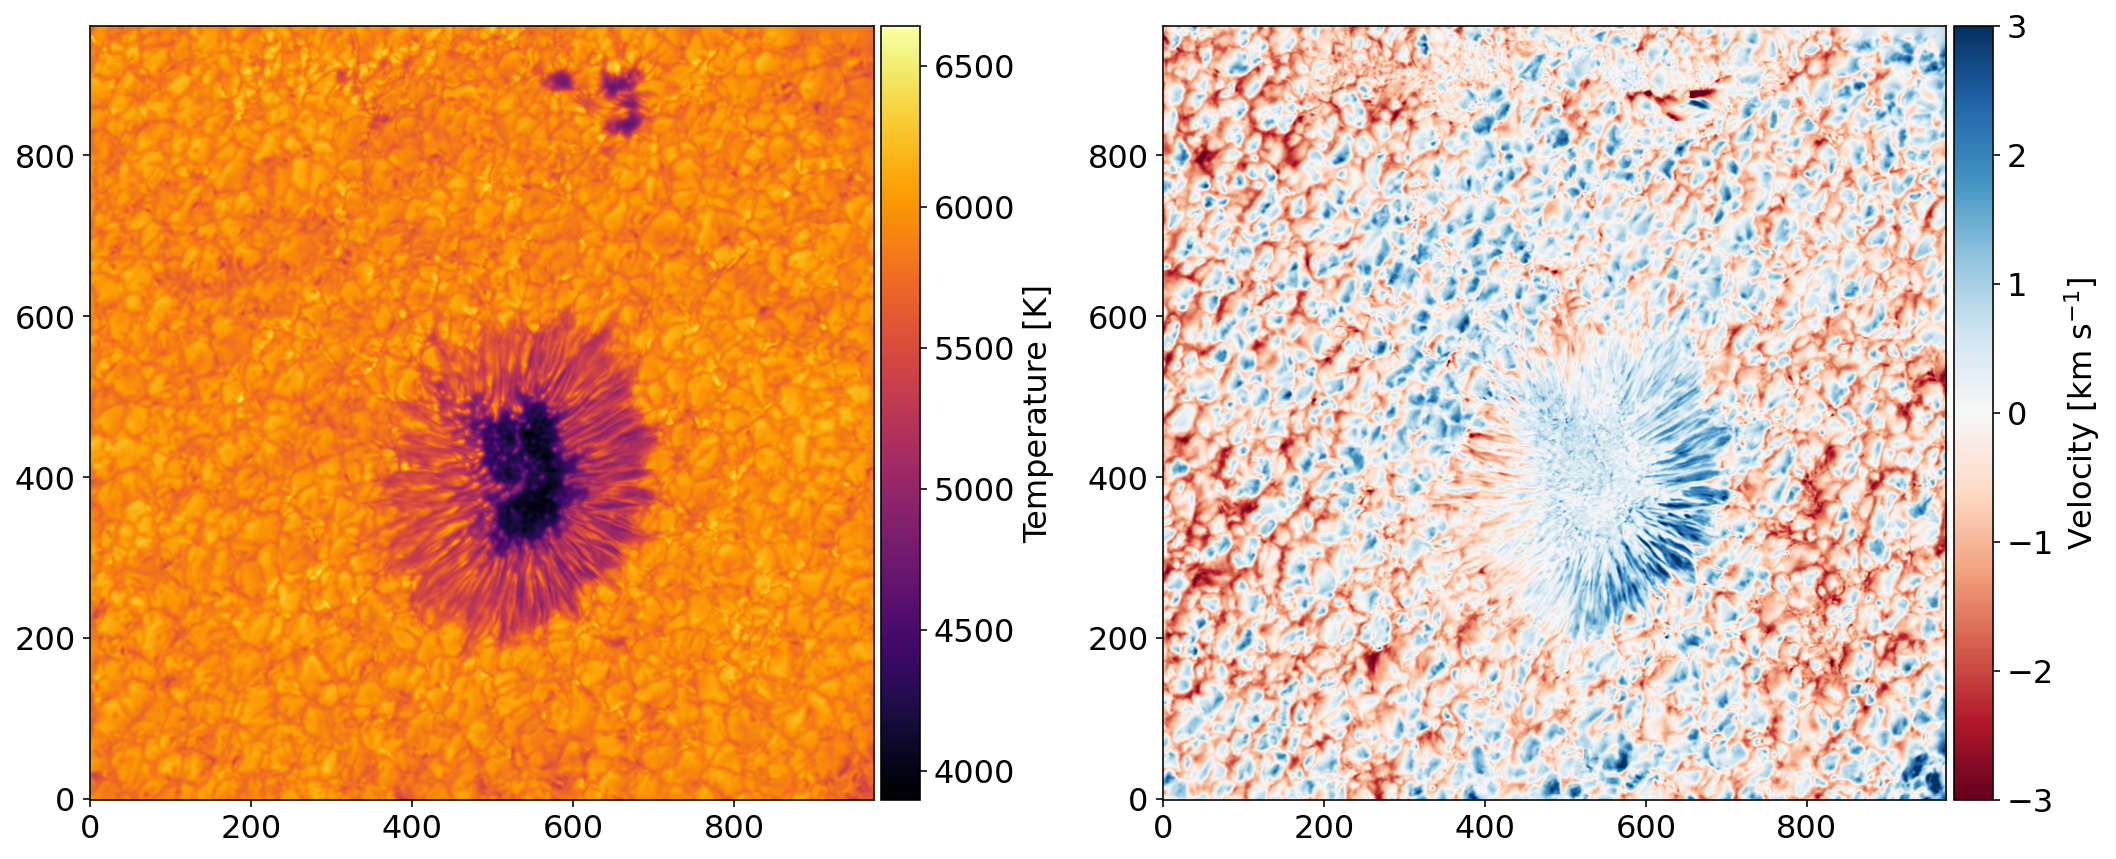

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,10)) 
im1 = plot_brightness_temperature(data, ax[0], wavelength_index=3, xmin=None, xmax=None, ymin=None, ymax=None)
im2 = plot_los_velocity(v_los, ax[1], xmin=None, xmax=None, ymin=None, ymax=None)

fig.tight_layout()

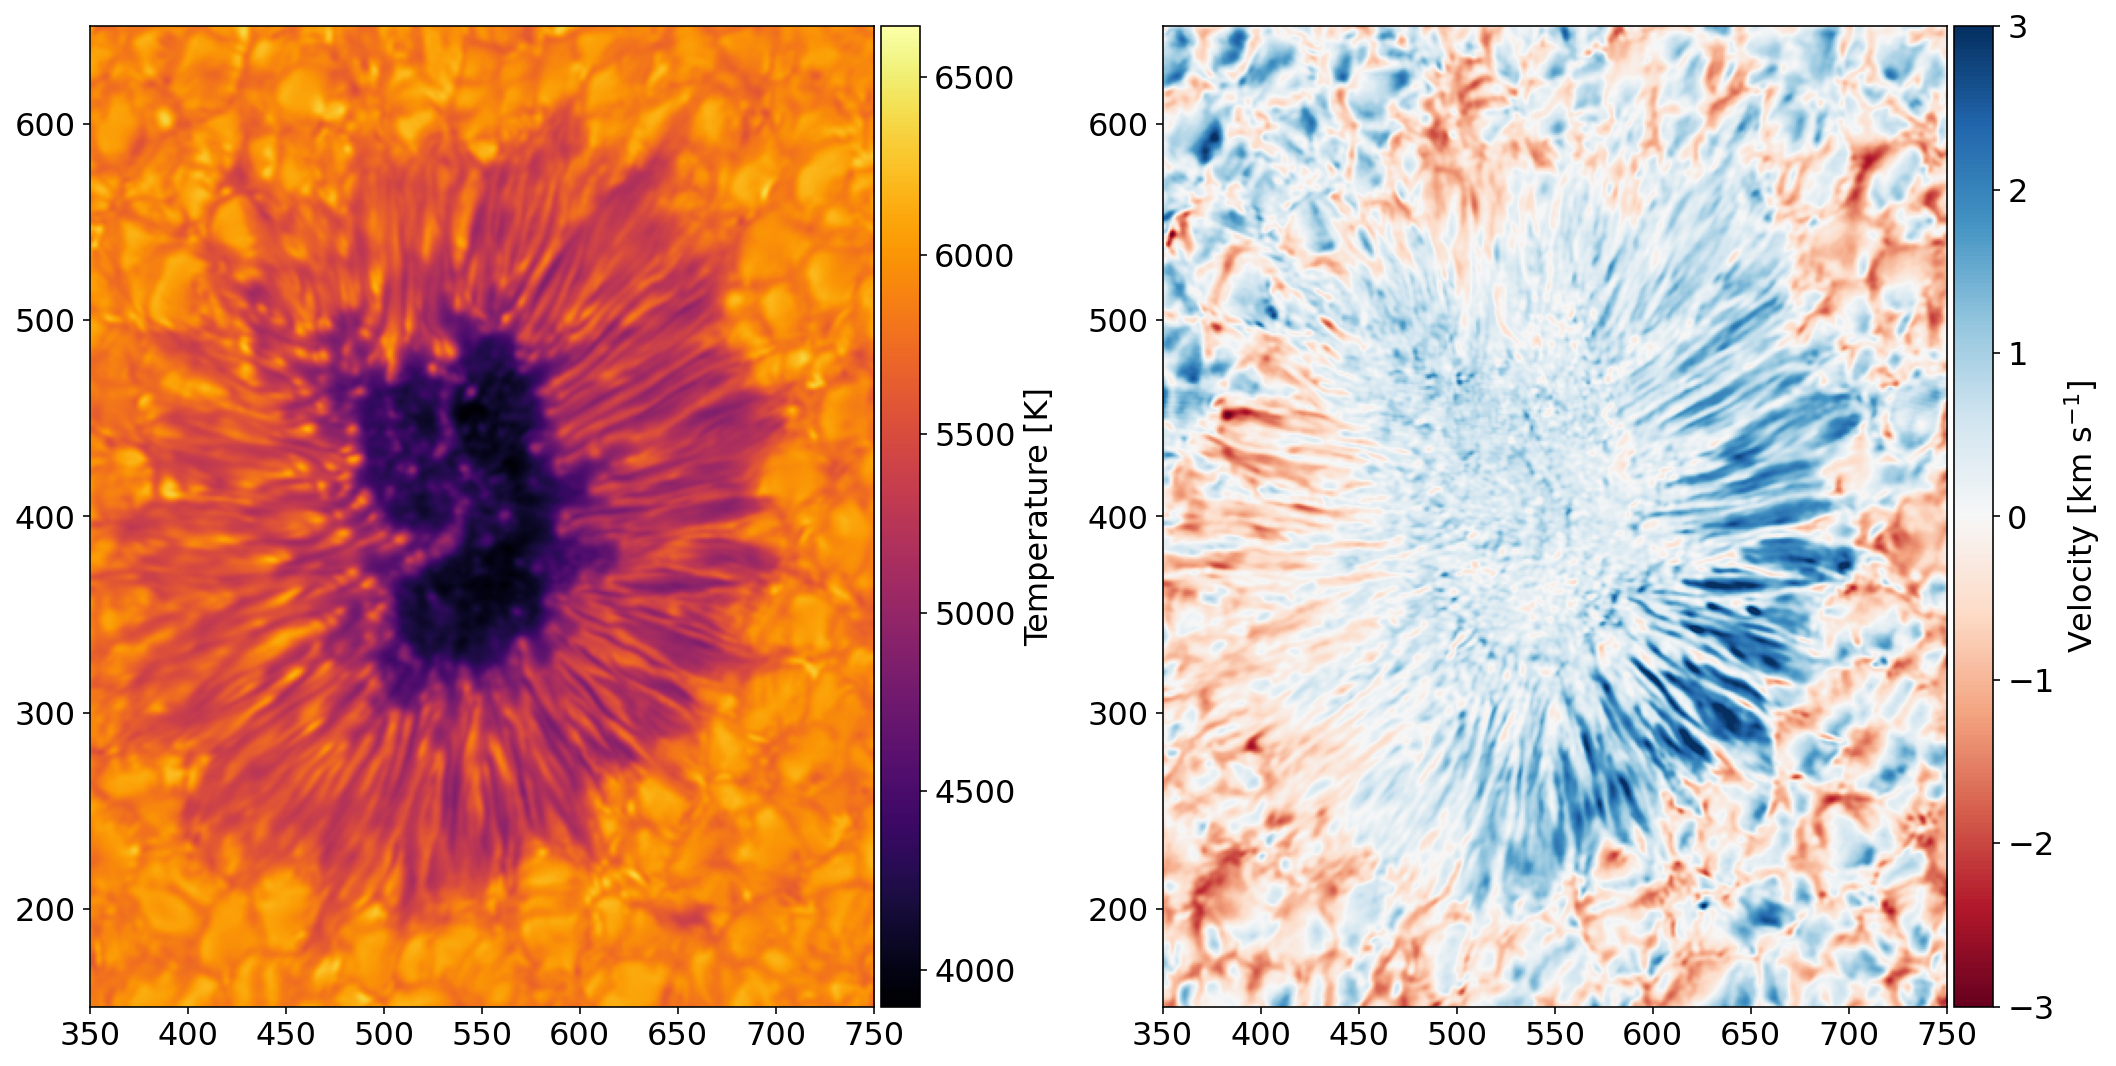

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,10)) 
im1 = plot_brightness_temperature(data, ax[0], wavelength_index=3, xmin=350, xmax=750, ymin=150, ymax=650)
im2 = plot_los_velocity(v_los, ax[1], xmin=350, xmax=750, ymin=150, ymax=650)

fig.tight_layout()

## Just checking if interpolation works better (it does)

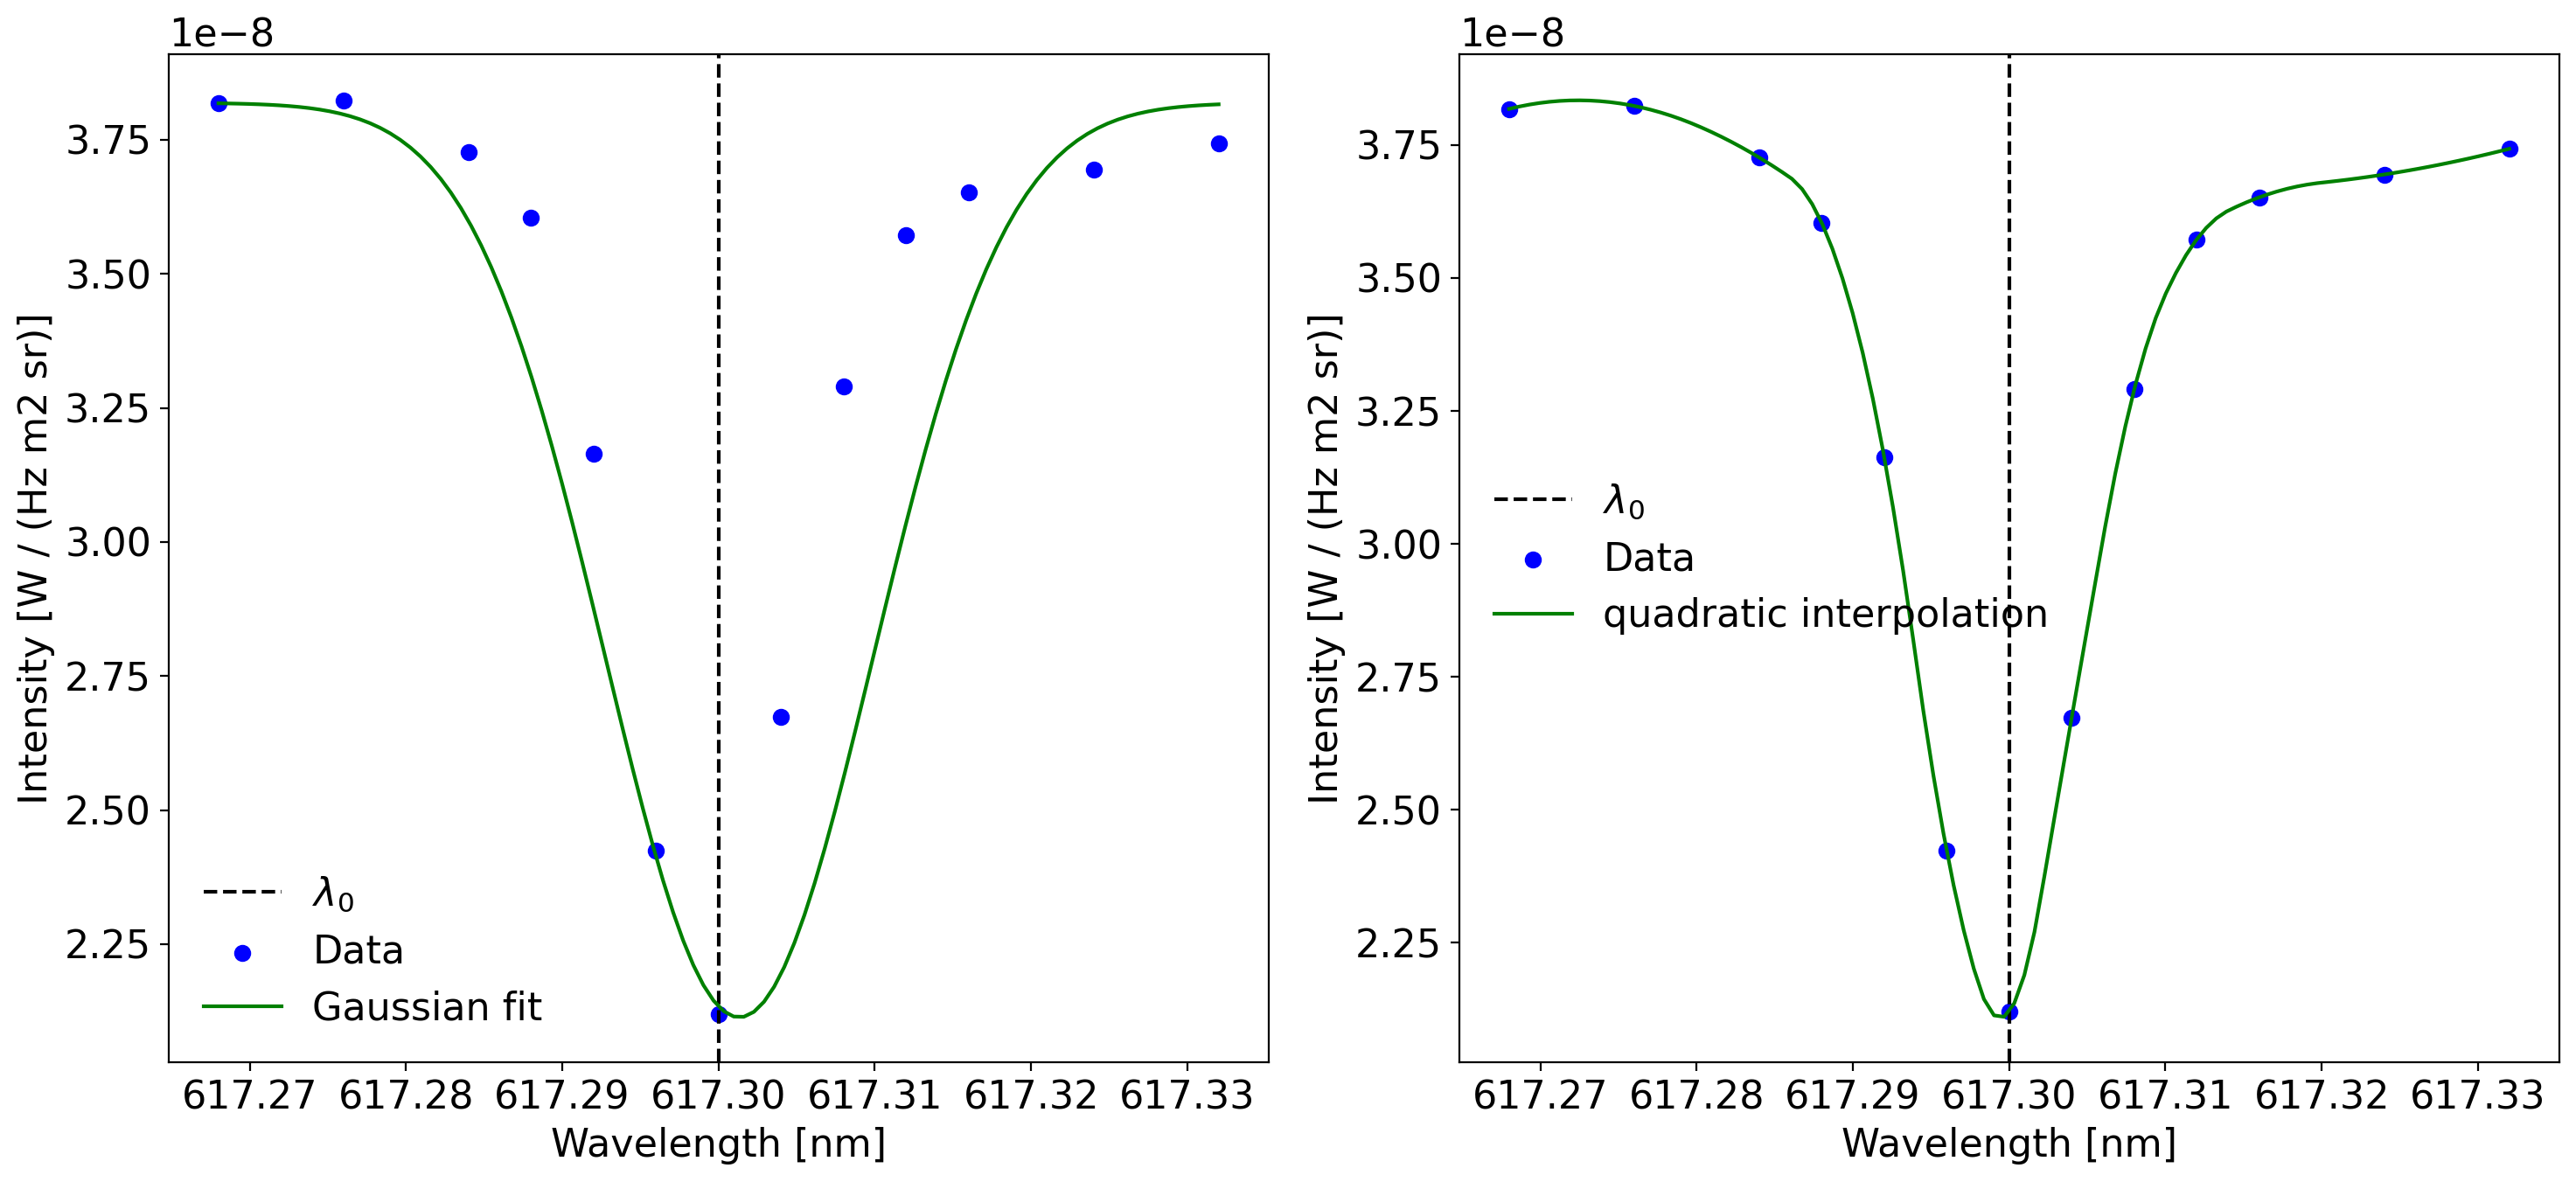

In [129]:
wavelengths = numpy.linspace(data['wavelength'][0], data['wavelength'][-1], 100)

plot_location =[100, 200]

fig, ax = plt.subplots(1,2, figsize=(15,7)) 
plot_gaussian_fit_on_intensity(data, moment1, moment2, wavelengths\
                           , x=plot_location[0], y=plot_location[1], ax=ax[0], rest_wavelength=rest_wavelength)

plot_interpolation_on_intensity(data, wavelengths\
                                , x=plot_location[0], y=plot_location[1]\
                                , ax=ax[1], kind_='quadratic', rest_wavelength=rest_wavelength)

fig.tight_layout()

## Magnetic field vs. intensity

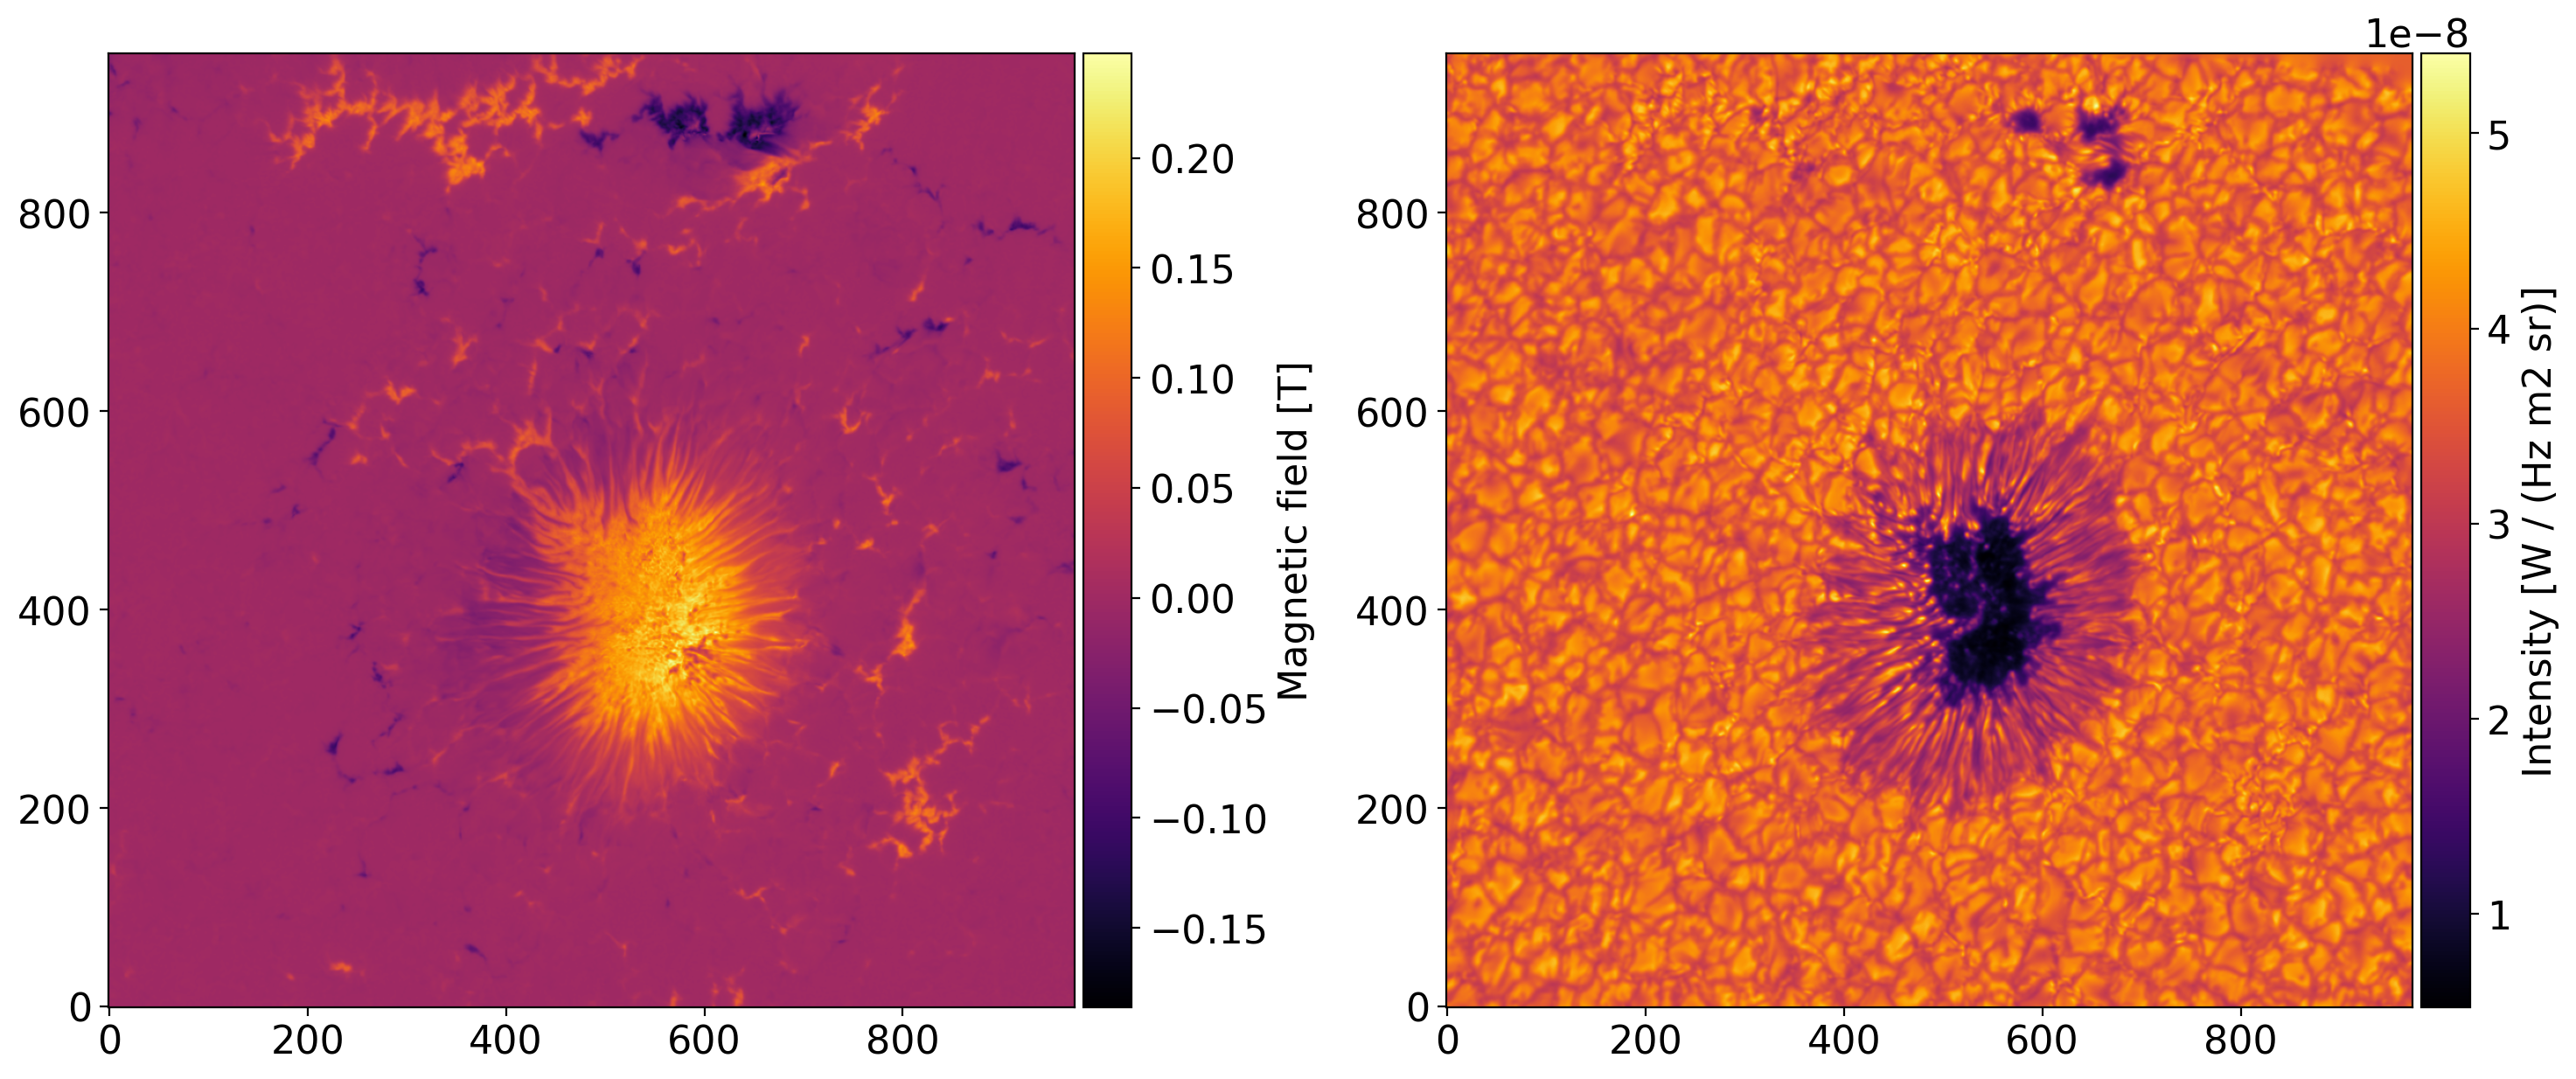

In [175]:
fig, ax = plt.subplots(1,2, figsize=(15,10)) 
im1 = plot_B_los(data, rest_wavelength, ax[0])
im2 = plot_intensity(data, ax[1], wavelength_index=0, xmin=None, xmax=None, ymin=None, ymax=None)

fig.tight_layout()

# STOP HERE

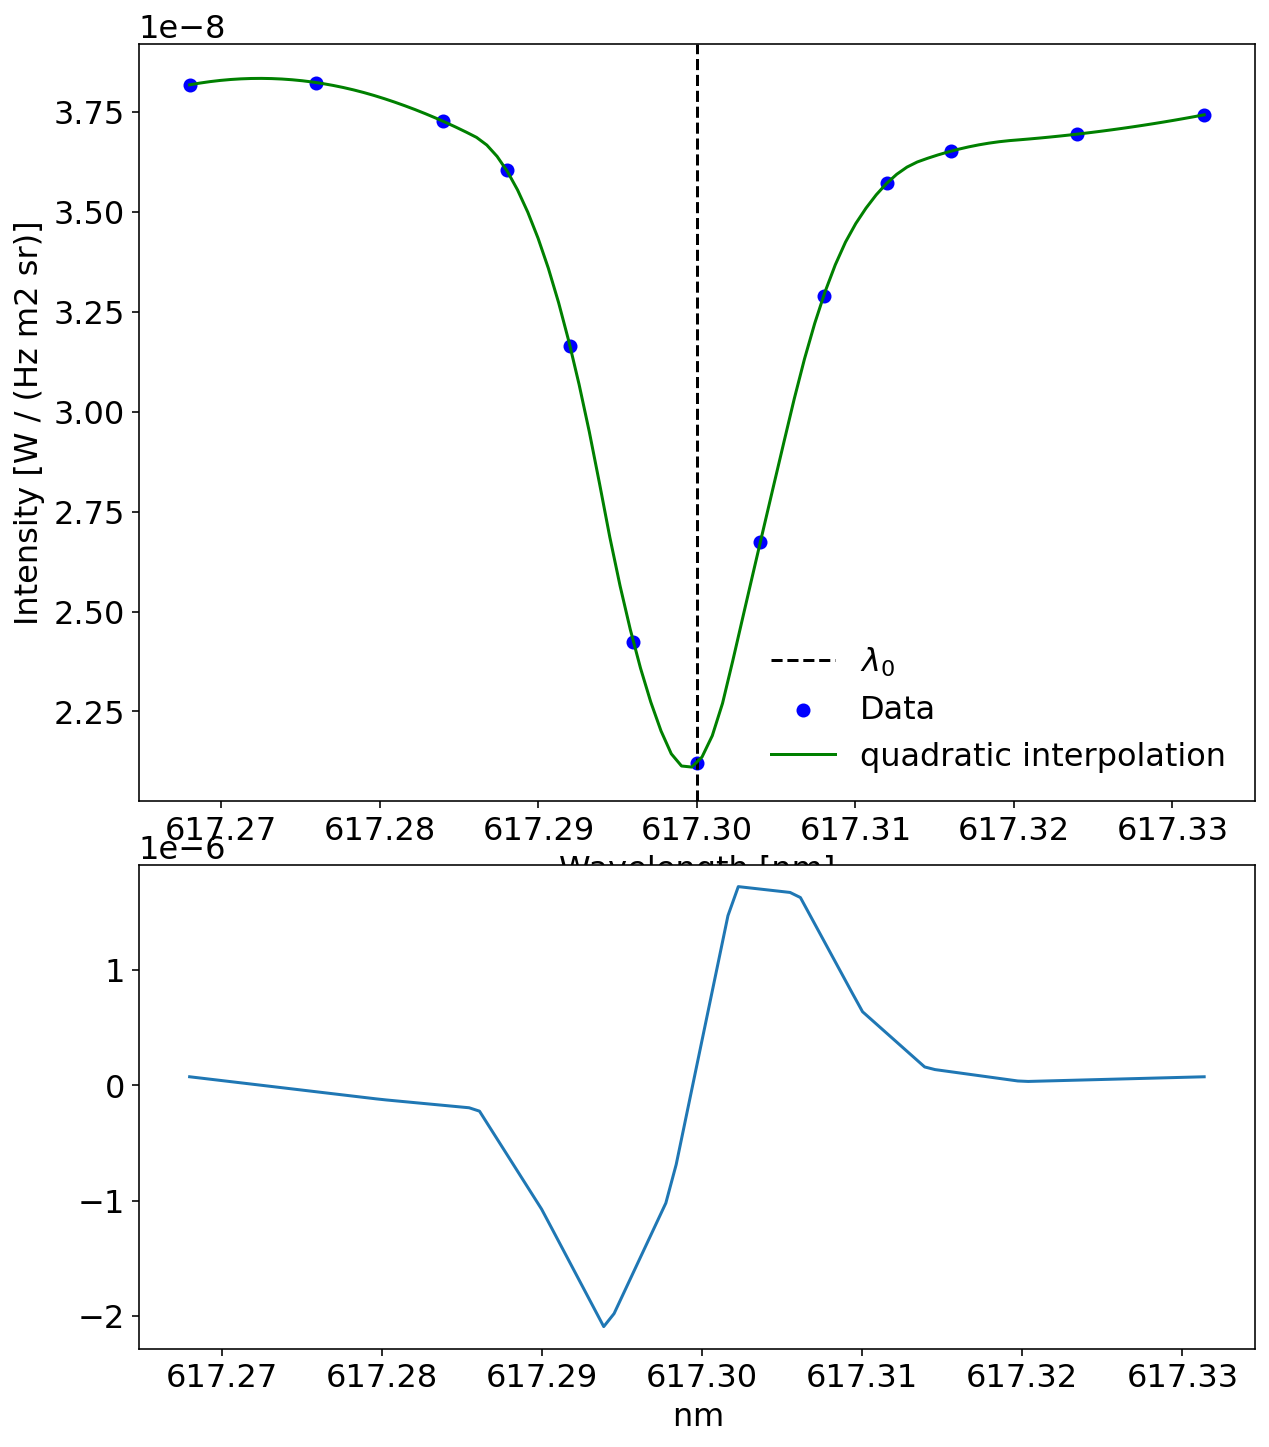

In [130]:
fig = plt.figure(figsize=(10, 12))
grid = plt.GridSpec(5, 1, wspace=0.4, hspace=0.3)
top_ax = fig.add_subplot(grid[0:3, :])
bot_ax = fig.add_subplot(grid[3:, :])

wavelengths = numpy.linspace(data['wavelength'][0], data['wavelength'][-1], 100)

plot_location =[100, 200]

plot_interpolation_on_intensity(data, wavelengths\
                                , x=plot_location[0], y=plot_location[1]\
                                , ax=top_ax, kind_='quadratic', rest_wavelength=rest_wavelength)


def derivative_function(x, dx, f):
    return (f(x+dx)-f(x))/dx
interpolation_function = interpolate.interp1d(data['wavelength'], data['intensity'][:, plot_location[0], plot_location[1]], kind='quadratic')
bot_ax.plot(wavelengths[:-1], derivative_function(wavelengths[:-1], 1e-6*units.nm, interpolation_function).value, label='Derivative')



In [ ]:
# Create some normally distributed data
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 3000).T

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()